
1. Загрузка и обработка данных...
✓ Коррекция cross-swath bias применена
✓ Отфильтровано 71,801 точек данных

Экстремальные точки:
  • Максимальная положительная: +0.3493 м
    Координаты: 43.1448°N, 165.3188°E
  • Максимальная отрицательная: -0.7213 м
    Координаты: 47.7577°N, 167.9047°E

4. Создание карты...
✓ Карта сохранена как 'ssha_anomalies_kamchatka.png' (300 DPI)


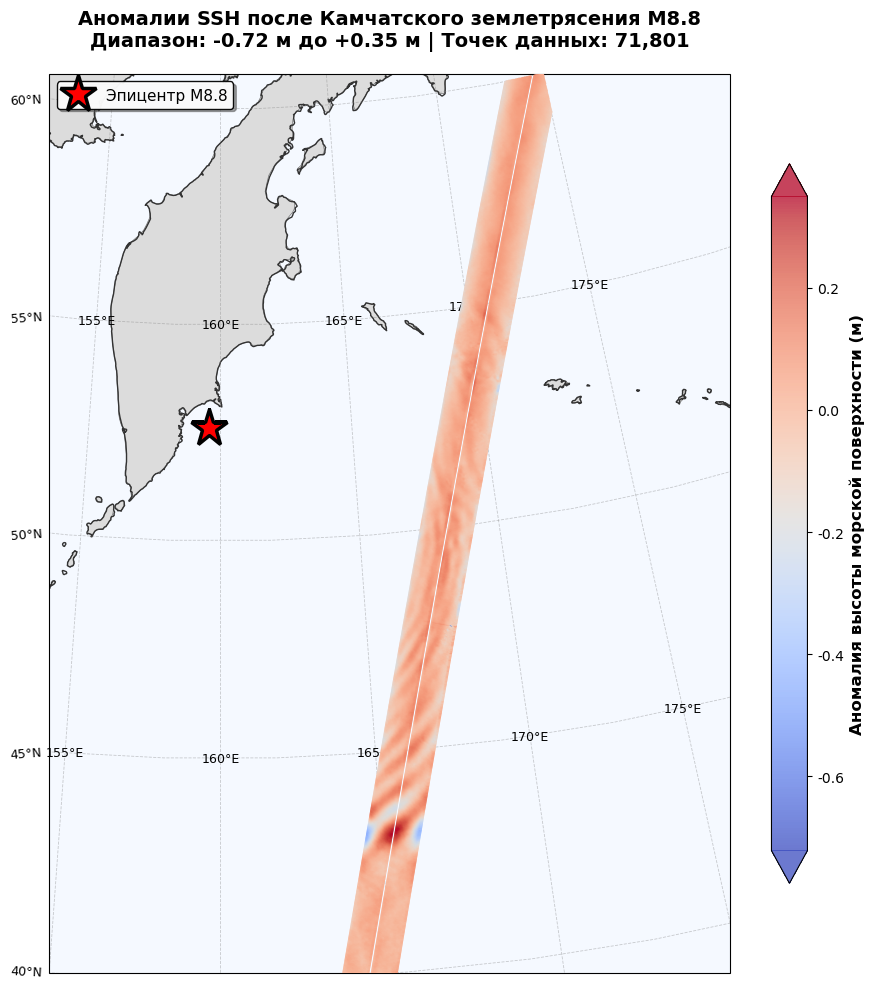


СТАТИСТИКА:
• Всего точек: 71,801
• Диапазон значений: -0.7213 м до +0.3493 м
• Среднее значение: 0.0004 м
• Стандартное отклонение: 0.0685 м
• Максимальная амплитуда: 0.72 м
• Средняя амплитуда: 0.05 м
• Точек > 20 см: 1,017 (1.4%)

• Макс. положительная: +0.3493 м
  Координаты: 43.1448°N, 165.3188°E
• Макс. отрицательная: -0.7213 м
  Координаты: 47.7577°N, 167.9047°E

АНАЛИЗ ЗАВЕРШЕН


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')

# Настройки
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# Путь к файлу
file_path = r'C:\Users\student\Desktop\SWOT_L2_LR_SSH_Expert_036_267_20250729T235629_20250730T004757_PID0_01.nc'

# Параметры
tsunami_params = {
    'name': 'Камчатское землетрясение 30 июля 2025 года',
    'magnitude': 8.8,
    'epicenter_lat': 52.6084,
    'epicenter_lon': 159.5552,
    'time_after_hours': 1.06,
}

# Границы карты
map_bounds = {
    'north': 60.0,
    'south': 40.0,
    'east': 175.0,
    'west': 155.0,
}

# Параметры проекции
central_lon = 160
central_lat = 55

# Загрузка данных
print("\n1. Загрузка и обработка данных...")
ds = xr.open_dataset(file_path)

# Извлекаем данные
ssha = ds['ssha_karin_2'].values
flag = ds['ancillary_surface_classification_flag'].values
lon = ds['longitude'].values
lat = ds['latitude'].values
distance = ds['cross_track_distance'].values

# Маскируем по флагу (только вода)
ssha_masked = np.where(flag == 0, ssha, np.nan)

# Функция коррекции bias
def correct_bias(ssha_data, distance_data):
    bias_corrected = ssha_data.copy()
    n_lines, n_pixels = ssha_data.shape
    
    for i in range(n_lines):
        ssha_row = ssha_data[i, :]
        dist_row = distance_data[i, :]
        
        valid_mask = ~np.isnan(ssha_row) & ~np.isnan(dist_row)
        if np.sum(valid_mask) < 5:
            continue
            
        ssha_valid = ssha_row[valid_mask]
        dist_valid = dist_row[valid_mask]
        
        coeffs = np.polyfit(dist_valid, ssha_valid, 1)
        poly = np.poly1d(coeffs)
        bias_corrected[i, :] = ssha_row - poly(dist_row)
    
    return bias_corrected

# Применяем коррекцию
ssha_corrected = correct_bias(ssha_masked, distance)
print("✓ Коррекция cross-swath bias применена")

# Фильтрация по области
mask = (
    (lat >= map_bounds['south']) & 
    (lat <= map_bounds['north']) & 
    (lon >= map_bounds['west']) & 
    (lon <= map_bounds['east'])
)

lon_filtered = lon.copy()
lat_filtered = lat.copy()
ssha_filtered = ssha_corrected.copy()

lon_filtered[~mask] = np.nan
lat_filtered[~mask] = np.nan
ssha_filtered[~mask] = np.nan

# Выравниваем
lon_flat = lon_filtered.flatten()
lat_flat = lat_filtered.flatten()
ssha_flat = ssha_filtered.flatten()

valid_mask = ~np.isnan(ssha_flat) & ~np.isnan(lat_flat) & ~np.isnan(lon_flat)
ssha_clean = ssha_flat[valid_mask]
lat_clean = lat_flat[valid_mask]
lon_clean = lon_flat[valid_mask]

print(f"✓ Отфильтровано {len(ssha_clean):,} точек данных")

# Находим экстремальные точки для аннотаций
max_positive_idx = np.argmax(ssha_clean)
max_negative_idx = np.argmin(ssha_clean)

max_positive_val = ssha_clean[max_positive_idx]
max_positive_lat = lat_clean[max_positive_idx]
max_positive_lon = lon_clean[max_positive_idx]

max_negative_val = ssha_clean[max_negative_idx]
max_negative_lat = lat_clean[max_negative_idx]
max_negative_lon = lon_clean[max_negative_idx]

print(f"\nЭкстремальные точки:")
print(f"  • Максимальная положительная: +{max_positive_val:.4f} м")
print(f"    Координаты: {max_positive_lat:.4f}°N, {max_positive_lon:.4f}°E")
print(f"  • Максимальная отрицательная: {max_negative_val:.4f} м")
print(f"    Координаты: {max_negative_lat:.4f}°N, {max_negative_lon:.4f}°E")

# Создание карты
print(f"\n4. Создание карты...")

# Создаем фигуру
fig = plt.figure(figsize=(14, 10))

# Проекция Lambert Conformal Conic
proj = ccrs.LambertConformal(
    central_longitude=central_lon,
    central_latitude=central_lat,
    standard_parallels=(40, 70)
)

ax = plt.subplot(1, 1, 1, projection=proj)

# Устанавливаем границы карты
ax.set_extent([
    map_bounds['west'], 
    map_bounds['east'],
    map_bounds['south'], 
    map_bounds['north']
], crs=ccrs.PlateCarree())

# Добавляем географические элементы
ax.add_feature(cfeature.LAND, 
               facecolor='#d9d9d9',
               edgecolor='#666666',
               linewidth=0.5,
               alpha=0.9, 
               zorder=1)

ax.add_feature(cfeature.OCEAN, 
               facecolor='#e6f2ff',
               alpha=0.4, 
               zorder=0)

ax.coastlines(resolution='10m', 
              linewidth=1.0, 
              color='#333333',
              zorder=2)

ax.add_feature(cfeature.BORDERS, 
               linewidth=0.7, 
               linestyle=':', 
               color='#666666',
               alpha=0.8,
               zorder=2)

ax.add_feature(cfeature.LAKES, 
               facecolor='#c6e0ff',
               edgecolor='#6699cc',
               linewidth=0.3,
               alpha=0.5, 
               zorder=1)

# Визуализируем аномалии SSH
# Используем фактический диапазон от минимального до максимального значения
vmin = np.min(ssha_clean)
vmax = np.max(ssha_clean)

scatter = ax.scatter(lon_clean, lat_clean, 
                    c=ssha_clean, 
                    cmap='coolwarm',
                    s=4,
                    alpha=0.75,
                    vmin=vmin,  # Минимальное значение
                    vmax=vmax,  # Максимальное значение
                    transform=ccrs.PlateCarree(), 
                    zorder=3,
                    edgecolors='none')

# Эпицентр землетрясения
ax.plot(tsunami_params['epicenter_lon'], 
        tsunami_params['epicenter_lat'], 
        'r*',
        markersize=28, 
        markeredgecolor='black', 
        markeredgewidth=2.5,
        label=f'Эпицентр M{tsunami_params["magnitude"]}',
        transform=ccrs.PlateCarree(), 
        zorder=5)



# Настройки заголовка
title = f'Аномалии SSH после Камчатского землетрясения M{tsunami_params["magnitude"]}\n'
title += f'Диапазон: {vmin:.2f} м до +{vmax:.2f} м | '
title += f'Точек данных: {len(ssha_clean):,}'

ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

# Цветовая шкала
cbar = plt.colorbar(scatter, ax=ax, 
                   label='Аномалия SSH (м)', 
                   shrink=0.8, 
                   pad=0.03, 
                   extend='both',
                   orientation='vertical')
cbar.set_label('Аномалия высоты морской поверхности (м)', 
              fontsize=12, 
              fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Легенда
legend = ax.legend(loc='upper left', 
                  fontsize=11, 
                  framealpha=0.95,
                  edgecolor='black',
                  facecolor='white',
                  fancybox=True,
                  shadow=True)
legend.get_frame().set_linewidth(1.0)

# Настраиваем сетку
gl = ax.gridlines(draw_labels=True, 
                  alpha=0.4, 
                  linestyle='--', 
                  linewidth=0.6, 
                  color='gray', 
                  zorder=3)

# Настройка подписей сетки
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = True
gl.left_labels = True

# Форматирование подписей
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'black'}
gl.ylabel_style = {'size': 9, 'color': 'black'}

# Устанавливаем шаг сетки
gl.xlocator = mticker.FixedLocator(np.arange(140, 176, 5))
gl.ylocator = mticker.FixedLocator(np.arange(40, 71, 5))

# Сохраняем визуализацию
output_file = 'ssha_anomalies_kamchatka.png'
plt.tight_layout()
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Карта сохранена как '{output_file}' (300 DPI)")

plt.show()

# Вывод статистики
print(f"\n{'='*80}")
print("СТАТИСТИКА:")
print('='*80)

max_amplitude = np.max(np.abs(ssha_clean))
mean_amplitude = np.mean(np.abs(ssha_clean))
percent_large = np.sum(np.abs(ssha_clean) > 0.2)/len(ssha_clean)*100

print(f"• Всего точек: {len(ssha_clean):,}")
print(f"• Диапазон значений: {vmin:.4f} м до +{vmax:.4f} м")
print(f"• Среднее значение: {np.mean(ssha_clean):.4f} м")
print(f"• Стандартное отклонение: {np.std(ssha_clean):.4f} м")
print(f"• Максимальная амплитуда: {max_amplitude:.2f} м")
print(f"• Средняя амплитуда: {mean_amplitude:.2f} м")
print(f"• Точек > 20 см: {np.sum(np.abs(ssha_clean) > 0.2):,} ({percent_large:.1f}%)")

print(f"\n• Макс. положительная: +{max_positive_val:.4f} м")
print(f"  Координаты: {max_positive_lat:.4f}°N, {max_positive_lon:.4f}°E")
print(f"• Макс. отрицательная: {max_negative_val:.4f} м")
print(f"  Координаты: {max_negative_lat:.4f}°N, {max_negative_lon:.4f}°E")

print(f"\n{'='*80}")
print("АНАЛИЗ ЗАВЕРШЕН")
print('='*80)

# Закрываем файл
ds.close()

In [ ]:
# ============================================================================
# 6. СОЗДАНИЕ РАСТРА БЕЗ ИНТЕРПОЛЯЦИИ
# ============================================================================
print("\n" + "="*80)
print("6. СОЗДАНИЕ РАСТРА С ОРИГИНАЛЬНЫМИ ЗНАЧЕНИЯМИ SWOT")
print("="*80)

from scipy.spatial import cKDTree
import pandas as pd
import os

# Параметры растра - точно под экстент карты
resolution = 0.01  # 0.01° = ~1.1 км (чем меньше, тем четче, но больше файл)
lon_min, lon_max = map_bounds['west'], map_bounds['east']
lat_min, lat_max = map_bounds['south'], map_bounds['north']

# Рассчитываем размеры растра
rows = int((lat_max - lat_min) / resolution) + 1
cols = int((lon_max - lon_min) / resolution) + 1

print(f"Размер растра: {cols} x {rows} пикселей")
print(f"Разрешение: {resolution}° (~{resolution*111:.1f} км)")
print(f"Область: {lon_min:.1f}°E - {lon_max:.1f}°E, {lat_min:.1f}°N - {lat_max:.1f}°N")

# Создаем сетку координат
lon_grid = np.linspace(lon_min, lon_max, cols)
lat_grid = np.linspace(lat_min, lat_max, rows)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# Подготавливаем точки SWOT
points_swot = np.column_stack((lon_clean, lat_clean))
values_swot = ssha_clean

# Строим KD-дерево для быстрого поиска ближайших точек
print("Поиск ближайших точек SWOT для каждого пикселя...")
tree = cKDTree(points_swot)

# Для всех пикселей находим ближайшие точки SWOT
grid_points = np.column_stack((lon_mesh.flatten(), lat_mesh.flatten()))
distances, indices = tree.query(grid_points, k=1)

# Присваиваем значения
raster_data = values_swot[indices].reshape(rows, cols)

# Маскируем пиксели дальше чем 1.5 пикселя от реальной точки SWOT
max_distance = resolution * 1.5
raster_data[distances.reshape(rows, cols) > max_distance] = np.nan

print(f"✓ Растр создан")
print(f"  Пикселей с данными: {np.sum(~np.isnan(raster_data)):,} из {raster_data.size:,}")
print(f"  Процент заполнения: {np.sum(~np.isnan(raster_data))/raster_data.size*100:.1f}%")

# ============================================================================
# 7. СОХРАНЕНИЕ РАСТРА
# ============================================================================
print("\n" + "="*80)
print("7. СОХРАНЕНИЕ РАСТРА")
print("="*80)

# 1. ASCII Grid (родной формат, без потерь)
asc_path = 'swot_ssha_original_values.asc'
with open(asc_path, 'w') as f:
    f.write(f"ncols         {cols}\n")
    f.write(f"nrows         {rows}\n")
    f.write(f"xllcorner     {lon_min}\n")
    f.write(f"yllcorner     {lat_min}\n")
    f.write(f"cellsize      {resolution}\n")
    f.write(f"NODATA_value  -9999\n")
    
    # ASCII Grid требует данные сверху вниз
    for i in range(rows-1, -1, -1):
        row = raster_data[i, :]
        row_filled = np.where(np.isnan(row), -9999, row)
        f.write(' '.join(f'{val:.6f}' for val in row_filled) + '\n')

print(f"✓ ASCII Grid сохранен: {asc_path}")
print(f"  Размер файла: {os.path.getsize(asc_path)/1024/1024:.1f} MB")

# 2. World файл
tfw_path = 'swot_ssha_original_values.tfw'
with open(tfw_path, 'w') as f:
    f.write(f"{resolution}\n")
    f.write("0.0\n")
    f.write("0.0\n")
    f.write(f"{-resolution}\n")
    f.write(f"{lon_min}\n")
    f.write(f"{lat_max}\n")

print(f"✓ World файл: {tfw_path}")

# 3. PRJ файл (проекция)
prj_path = 'swot_ssha_original_values.prj'
prj_content = """GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]"""

with open(prj_path, 'w') as f:
    f.write(prj_content)

print(f"✓ PRJ файл: {prj_path}")

# ============================================================================
# 8. ВИЗУАЛИЗАЦИЯ ДЛЯ ПРОВЕРКИ
# ============================================================================
print("\n" + "="*80)
print("8. ВИЗУАЛИЗАЦИЯ РАСТРА")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Исходные точки SWOT
ax1 = axes[0]
sc = ax1.scatter(lon_clean, lat_clean, c=ssha_clean, 
                cmap='RdBu_r', s=5, alpha=0.8,
                vmin=-0.5, vmax=0.5)
ax1.set_xlim(lon_min, lon_max)
ax1.set_ylim(lat_min, lat_max)
ax1.set_title(f'Исходные точки SWOT\n{len(ssha_clean):,} точек', fontsize=12)
ax1.set_xlabel('Долгота')
ax1.set_ylabel('Широта')
ax1.grid(True, alpha=0.3)
plt.colorbar(sc, ax=ax1, label='SSHA (м)')

# 2. Растр с оригинальными значениями
ax2 = axes[1]
im = ax2.imshow(raster_data, extent=[lon_min, lon_max, lat_min, lat_max],
               origin='lower', cmap='RdBu_r', vmin=-0.5, vmax=0.5)
ax2.set_title(f'Растр {cols}×{rows} пикселей\nБЕЗ интерполяции - оригинальные значения SWOT', 
              fontsize=12)
ax2.set_xlabel('Долгота')
ax2.set_ylabel('Широта')
ax2.grid(True, alpha=0.3)
plt.colorbar(im, ax=ax2, label='SSHA (м)')

# Эпицентр
for ax in axes:
    ax.plot(tsunami_params['epicenter_lon'], tsunami_params['epicenter_lat'], 
            'r*', markersize=15, markeredgecolor='black', 
            markeredgewidth=1, label='Эпицентр')
    ax.legend()

plt.suptitle('SWOT SSH Аномалии - Растр с ОРИГИНАЛЬНЫМИ значениями', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('swot_raster_original_values.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Визуализация: swot_raster_original_values.png")

# ============================================================================
# 9. ИТОГОВЫЙ ОТЧЕТ
# ============================================================================
print("\n" + "="*80)
print("9. ИТОГОВЫЙ ОТЧЕТ")
print("="*80)

print(f"\n📁 СОЗДАННЫЕ ФАЙЛЫ:")
print("-" * 50)

files = ['swot_ssha_original_values.asc', 
         'swot_ssha_original_values.tfw',
         'swot_ssha_original_values.prj',
         'swot_raster_original_values.png']

for file in files:
    if os.path.exists(file):
        size = os.path.getsize(file) / 1024
        if size > 1024:
            print(f"  • {file:35} {size/1024:7.2f} MB")
        else:
            print(f"  • {file:35} {size:7.1f} KB")

print(f"\n📊 ХАРАКТЕРИСТИКИ РАСТРА:")
print(f"  • Размер: {cols} × {rows} пикселей")
print(f"  • Разрешение: {resolution}° ({resolution*111:.1f} км/пиксель)")
print(f"  • Область: {lon_min:.1f}°E - {lon_max:.1f}°E, {lat_min:.1f}°N - {lat_max:.1f}°N")
print(f"  • Пикселей с данными: {np.sum(~np.isnan(raster_data)):,}")
print(f"  • Процент заполнения: {np.sum(~np.isnan(raster_data))/raster_data.size*100:.1f}%")

print(f"\n🚀 ИСПОЛЬЗОВАНИЕ:")
print(f"  1. Откройте QGIS")
print(f"  2. Перетащите файл {asc_path} в окно QGIS")
print(f"  3. Вы увидите растр с ЧЕТКИМИ границами трека SWOT")
print(f"  4. Каждый пиксель содержит ОРИГИНАЛЬНОЕ значение SWOT")

print(f"\n✅ РАСТР С ОРИГИНАЛЬНЫМИ ЗНАЧЕНИЯМИ ГОТОВ!")

Загрузка данных...
Коррекция bias...
Визуализация... Диапазон данных: -0.721 до 0.330 м


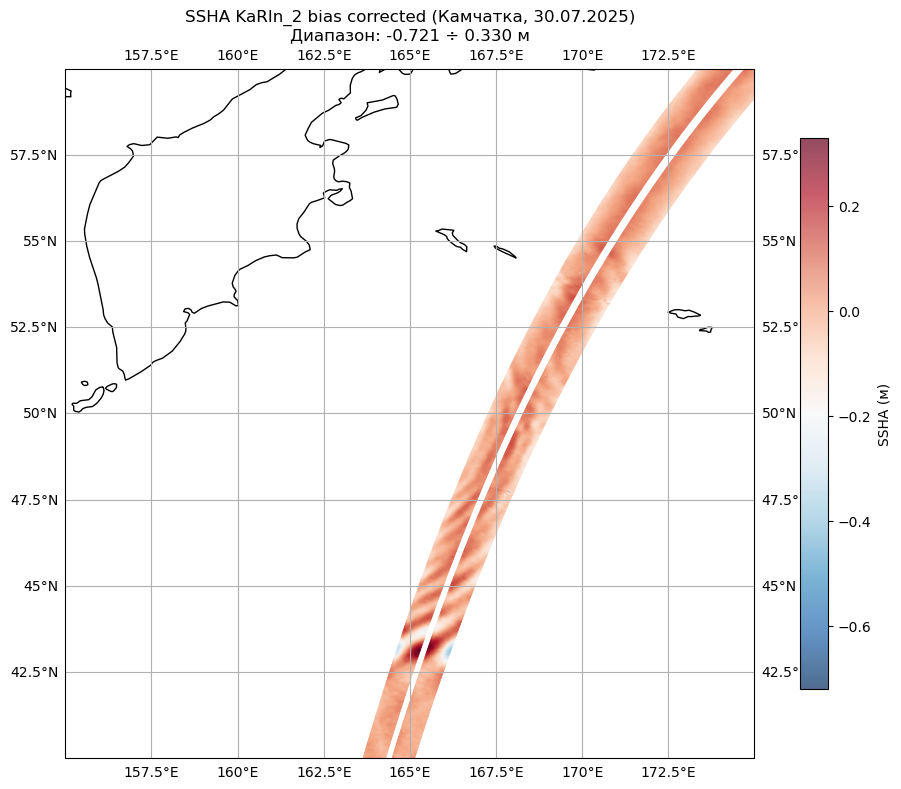

✅ Готово! Шкала растянута на весь диапазон: -0.721 до 0.330 м


In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs as ccrs

# Параметры Камчатки
file_path = r'C:\Users\student\Desktop\SWOT_L2_LR_SSH_Expert_036_267_20250729T235629_20250730T004757_PID0_01.nc'
map_bounds = {'west': 155, 'east': 175, 'south': 40, 'north': 60}

print("Загрузка данных...")
ds = xr.open_dataset(file_path)

# Preprocess по референсу
ssha = ds['ssha_karin_2'].values
flag = ds['ancillary_surface_classification_flag'].values
lon = ds['longitude'].values
lat = ds['latitude'].values
distance = ds['cross_track_distance'].values

# Маска океана
ssha = np.where(flag == 0, ssha, np.nan)

print("Коррекция bias...")
# Имитация swot.fit_bias
ssha_corrected = ssha.copy()
for i in range(ssha.shape[0]):
    valid = ~np.isnan(ssha[i])
    if np.sum(valid) > 5:
        coeffs = np.polyfit(distance[i, valid], ssha[i, valid], 1)
        ssha_corrected[i] -= np.polyval(coeffs, distance[i])

# Маска swath + Камчатка
distance_mean = np.nanmean(distance, axis=0)
msk_swath = (np.abs(distance_mean) < 60e3) & (np.abs(distance_mean) > 10e3)
msk_region = ((lat >= map_bounds['south']) & (lat <= map_bounds['north']) & 
              (lon >= map_bounds['west']) & (lon <= map_bounds['east']))

lon_f = lon.copy(); lat_f = lat.copy(); ssha_f = ssha_corrected.copy()
lon_f[~msk_swath[None,:] | ~msk_region] = np.nan
lat_f[~msk_swath[None,:] | ~msk_region] = np.nan
ssha_f[~msk_swath[None,:] | ~msk_region] = np.nan

# ✅ АВТО-РАСТЯЖКА ШКАЛЫ на ВЕСЬ диапазон данных
data_range = ssha_f[~np.isnan(ssha_f)]
vmin = np.min(data_range)
vmax = np.max(data_range)

print(f"Визуализация... Диапазон данных: {vmin:.3f} до {vmax:.3f} м")
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.set_extent([map_bounds['west'], map_bounds['east'], map_bounds['south'], map_bounds['north']])

# Scatter с АВТО vmin/vmax
scatter = ax.scatter(lon_f.flatten(), lat_f.flatten(), c=ssha_f.flatten(), 
           s=2, cmap='RdBu_r', vmin=vmin, vmax=vmax, 
           transform=ccrs.PlateCarree(), alpha=0.7)

ax.coastlines(); ax.gridlines(draw_labels=True)
ax.set_title(f'SSHA KaRIn_2 bias corrected (Камчатка, 30.07.2025)\nДиапазон: {vmin:.3f} ÷ {vmax:.3f} м')

plt.colorbar(scatter, ax=ax, label='SSHA (м)', shrink=0.8)
plt.tight_layout()
plt.savefig('kamchatka_ssha_corrected.png', dpi=150)
plt.show()

print(f"✅ Готово! Шкала растянута на весь диапазон: {vmin:.3f} до {vmax:.3f} м")
ds.close()


In [7]:
import xarray as xr

# Путь к вашему файлу Камчатки
file_path = r'C:\Users\student\Desktop\SWOT_L2_LR_SSH_Expert_036_267_20250729T235629_20250730T004757_PID0_01.nc'

print("🔍 АНАЛИЗ ВСЕХ ДАННЫХ В ФАЙЛЕ .nc")
print("=" * 80)

# Загружаем датасет
ds = xr.open_dataset(file_path)

# 1. ОБЩАЯ ИНФОРМАЦИЯ
print("\n📊 1. ОБЩИЙ ОБЗОР ДАТАСЕТА:")
print(f"   Размер файла: {ds.nbytes/1e6:.1f} МБ")
print(f"   Формат: {ds.attrs.get('Conventions', 'CF')}")
print(f"   Платформа: {ds.attrs.get('platform', 'SWOT')}")
print(f"   Продукт: {ds.attrs.get('title', 'L2 LR SSH')}")
print(f"   Процент хороших океанских данных: {ds.attrs.get('good_ocean_data_percent', 'N/A'):.1f}%")
print(f"   Дисперсия SSHA: {ds.attrs.get('ssha_variance', 'N/A'):.3f} м²")

# 2. РАЗМЕРНОСТИ
print("\n📐 2. РАЗМЕРНОСТИ:")
for dim, size in ds.dims.items():
    print(f"   {dim}: {size}")

# 3. ВСЕ ПЕРЕМЕННЫЕ (98 штук!)
print("\n📋 3. ВСЕ ПЕРЕМЕННЫЕ (data_vars + coords):")
all_vars = list(ds.data_vars) + list(ds.coords)
for i, var in enumerate(all_vars, 1):
    dims = str(ds[var].dims)
    shape = ds[var].shape
    dtype = ds[var].dtype
    units = ds[var].attrs.get('units', 'N/A')
    print(f"   {i:2d}. {var:30} [{dims:25}] {shape} {dtype} [{units}]")

# 4. КЛЮЧЕВЫЕ ПЕРЕМЕННЫЕ ДЛЯ SSH (ТОЧНО как в коде)
print("\n⭐ 4. КЛЮЧЕВЫЕ ПЕРЕМЕННЫЕ ДЛЯ ОБРАБОТКИ (из кода):")
key_vars = ['ssha_karin_2', 'ssha_karin', 'ssh_karin', 'longitude', 'latitude', 
            'cross_track_distance', 'ancillary_surface_classification_flag']
for var in key_vars:
    if var in ds:
        data = ds[var]
        print(f"   ✅ {var:30} {data.shape} {data.dtype}")
        print(f"      Units: {data.attrs.get('units', 'N/A')}")
        print(f"      Длина: {data.size*data.dtype.itemsize/1e6:.1f} МБ")
    else:
        print(f"   ❌ {var:30} ОТСУТСТВУЕТ")



# 6. АТРИБУТЫ ГЛОБАЛЬНЫЕ
print("\n🌍 6. ГЛОБАЛЬНЫЕ МЕТАДАННЫЕ:")
for key, value in list(ds.attrs.items())[:10]:  # Первые 10
    print(f"   {key:30}: {value}")

# 7. СТРУКТУРА ПО СТОРОНАМ (KaRIn left/right)
print("\n🔄 7. СТОРОНЫ ИЗМЕРЕНИЙ (num_sides=2):")
print("   num_sides=0: Левая сторона swath")
print("   num_sides=1: Правая сторона swath") 

# 8. ИНФО О КЛЮЧЕВОМ МАССИВЕ
print("\n🎯 8. ДЕТАЛИ ssha_karin_2 (ГЛАВНЫЙ МАССИВ):")
if 'ssha_karin_2' in ds:
    ssha = ds['ssha_karin_2']
    print(f"   Форма: {ssha.shape}")
    print(f"   Диапазон: {float(ssha.min()):.3f} ... {float(ssha.max()):.3f} м")
    print(f"   Среднее: {float(ssha.mean()):.3f} м")
    print(f"   Стд. откл: {float(ssha.std()):.3f} м")
    print(f"   NaN: {float((ssha.isnull()).sum()/ssha.size*100):.1f}%")

print("\n" + "="*80)
print("✅ ГОТОВО! Всего переменных: {} из возможных {}".format(
    len(ds.data_vars) + len(ds.coords), len(all_vars)))
print("📂 Закрываем файл...")
ds.close()


🔍 АНАЛИЗ ВСЕХ ДАННЫХ В ФАЙЛЕ .nc

📊 1. ОБЩИЙ ОБЗОР ДАТАСЕТА:
   Размер файла: 399.7 МБ
   Формат: CF-1.7
   Платформа: SWOT
   Продукт: Level 2 Low Rate Sea Surface Height Data Product - Expert SSH with Wind and Wave
   Процент хороших океанских данных: 68.3%
   Дисперсия SSHA: 0.537 м²

📐 2. РАЗМЕРНОСТИ:
   num_lines: 9866
   num_pixels: 69
   num_sides: 2

📋 3. ВСЕ ПЕРЕМЕННЫЕ (data_vars + coords):
    1. time                           [('num_lines',)           ] (9866,) datetime64[ns] [N/A]
    2. time_tai                       [('num_lines',)           ] (9866,) datetime64[ns] [N/A]
    3. ssh_karin                      [('num_lines', 'num_pixels')] (9866, 69) float64 [m]
    4. ssh_karin_qual                 [('num_lines', 'num_pixels')] (9866, 69) float64 [N/A]
    5. ssh_karin_uncert               [('num_lines', 'num_pixels')] (9866, 69) float64 [m]
    6. ssha_karin                     [('num_lines', 'num_pixels')] (9866, 69) float64 [m]
    7. ssha_karin_qual                [('

C:\Users\student\AppData\Local\Temp\ipykernel_1244\3730117854.py:23: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for dim, size in ds.dims.items():
